# GAN Development - Kochems Approach


## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import MinMaxScaler
import io
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import csv
from collections import defaultdict
from data_reader import DataReader
from torch.autograd import Variable, grad
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import plotly.figure_factory as ff
import kaleido


np.set_printoptions(threshold=np.inf)
torch.manual_seed(42)
np.random.seed(42)

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


## Read in Data

### Functions to preprocess data

In [3]:
def convert_ask_bid_int(dataset):
    mask_ask = np.char.endswith(dataset[:,:,2], 'ask')
    mask_bid = np.char.endswith(dataset[:,:,2], 'bid')
    dataset[:,:,2][mask_ask] = '1'
    dataset[:,:,2][mask_bid] = '0'
    dataset = dataset.astype(np.float32)
    return dataset
    
    
def get_dataset_max_price(dataset, rows_per_orderbook, level = -1):
    index_on_each_OB = 0
    if level != -1:
        index_on_each_OB = (rows_per_orderbook//2-(level))
    last_row_prices = dataset[:, index_on_each_OB, 0]
    max_val = np.max(last_row_prices)
    return max_val

def get_dataset_min_price(dataset, rows_per_orderbook, level = -1):
    index_on_each_OB = -1
    if level != -1:
        index_on_each_OB = (rows_per_orderbook//2+(level-1))
    first_row_prices = dataset[:, index_on_each_OB, 0]
    min_val = np.min(first_row_prices)
    return min_val

def make_histogram_from_dataset(dataset, rows_per_orderbook = 100, bin_width = 0.5, level = -1):
    X_train = []
    hist_max = get_dataset_max_price(dataset, rows_per_orderbook, level)
    hist_min = get_dataset_min_price(dataset, rows_per_orderbook, level)
    print("range: ", hist_min, " ", hist_max)
    num_bins = int(np.ceil((hist_max-hist_min) / bin_width))
    bins = np.linspace(hist_min, hist_max, num_bins)
    for i in range(len(dataset)):
        orderbook = dataset[i]
        price = orderbook[:,0]
        quantity = orderbook[:,1]
        quantity[orderbook[:, 2] == 0] *= -1
        hist, bin_edges = np.histogram(price, bins=bins, weights=quantity)
        X_train.append(hist)
    X_train = np.array(X_train)
    return X_train, hist_min, hist_max, bins

def make_centred_LOB_snapshots(histograms, level = 1):
    X_train = []
    y_train = []
    for i in range(len(histograms)-1):
        current_OB = histograms[i]
        next_OB = histograms[i+1]
        j = -1
        while j < len(current_OB)-1 and not (current_OB[j] < 0 and current_OB[j+1] > 0): j+=1
        j+=1
        
        current_start_index = j-level
        current_subarray_size = 2 * level
        current_centre_LOB_snapshot = current_OB[current_start_index: current_start_index + current_subarray_size]
        
        next_subarray_size = 2 * current_subarray_size
        next_centre_LOB_snapshot = next_OB[current_start_index - level: (current_start_index - level) + next_subarray_size]
        
        if np.any(next_centre_LOB_snapshot == 0):
            continue
        
        X_train.append(current_centre_LOB_snapshot)
        y_train.append(next_centre_LOB_snapshot)
    
    X_train = np.vstack(X_train)
    y_train = np.vstack(y_train)
    
    return X_train, y_train
        
def normalization(X_train, c=8):
    sqrt_abs_over_c = np.sqrt(np.abs(X_train)) / c
    with_sign = np.sign(X_train) * sqrt_abs_over_c
    return with_sign

def get_centre_of_LOB(X_t_delta_t, level=3):
    index = -1
    for i in range(len(X_t_delta_t)-1):
        if X_t_delta_t[i] < 0 and X_t_delta_t[i+1]>0: index = i+1
    return X_t_delta_t[(index-level): (index-level) + 2 * level]

def get_centre_of_LOB_dataset(X_t_delta_t_dataset, level = 3):
    centres = []
    for i in range(len(X_t_delta_t_dataset)):
        if np.any(X_t_delta_t_dataset[i] == 0): continue
        centre = get_centre_of_LOB(X_t_delta_t_dataset[i], level)
        if centre.size != 6: continue
        centres.append(centre)
    np.array(centres)
    return centres
            

### Functions to post-process data

In [4]:
def reverse_normalization(X_train_normalized, c=8):
    if not isinstance(X_train_normalized, np.ndarray) and X_train_normalized.device.type == 'cuda':
        X_train_normalized = X_train_normalized.cpu()
    unscaled_data = X_train_normalized * c
    X_train = np.sign(X_train_normalized) * (unscaled_data ** 2)
    return X_train
    

### Functions to graph

In [5]:
def draw_avg_centre_comparison(X_t_delta_t_generated_dataset, real_dataset, level = 3):
    generated_dataset_centres = get_centre_of_LOB_dataset(X_t_delta_t_generated_dataset, level)
    mean_real = np.mean(real_dataset, axis=0)
    mean_fake = np.mean(generated_dataset_centres, axis=0)
    interleaved_array = np.empty(mean_real.size + mean_fake.size, dtype=mean_real.dtype)
    interleaved_array[0::2] = mean_real
    interleaved_array[1::2] = mean_fake
    indices = np.arange(len(interleaved_array))
    return indices, interleaved_array

### Actually reading in data

In [6]:
data_reader = DataReader("./orderbook_snapshots.csv", rows_per_orderbook=100)
data_reader.read_csv()
X_train_raw = data_reader.get_data()
X_train_raw = convert_ask_bid_int(X_train_raw)
print(X_train_raw.shape)

(78252, 100, 3)


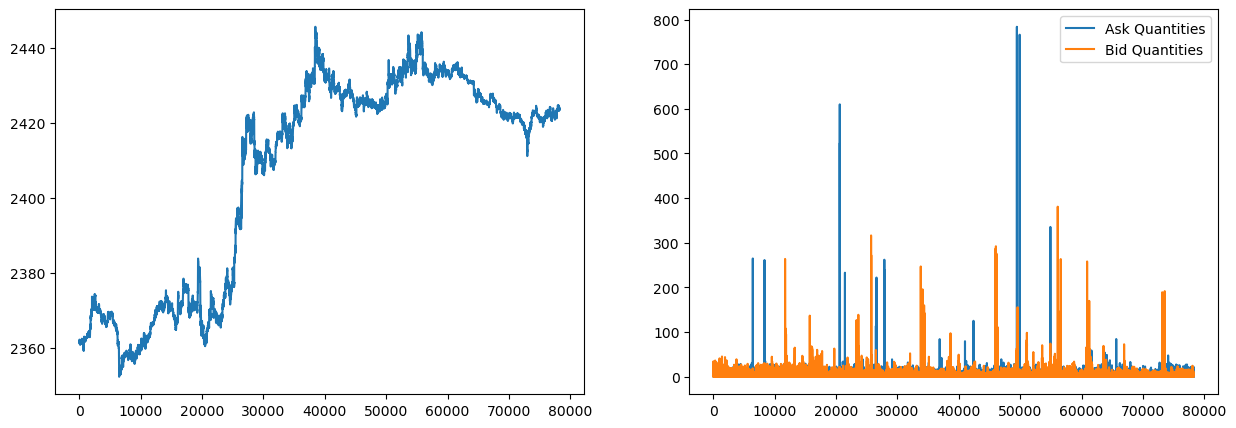

In [7]:
best_prices = (X_train_raw[:, 49, 0] + X_train_raw[:, 50, 0]) /2
best_ask_quantities = X_train_raw[:, 49, 1]
best_bid_quantities = np.abs(X_train_raw[:, 50, 1])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(best_prices, label='Prices')
axes[1].plot(best_ask_quantities, label='Ask Quantities')
axes[1].plot(best_bid_quantities, label='Bid Quantities')
plt.legend()
plt.show()

### Preprocess data

In [8]:
histograms, price_min, price_max, bins = make_histogram_from_dataset(X_train_raw, rows_per_orderbook=100, bin_width=0.5, level=-1)
print(histograms.shape)
print(bins)

range:  2346.7   2452.7
(78252, 211)
[2346.69995117 2347.20232084 2347.70469051 2348.20706018 2348.70942984
 2349.21179951 2349.71416918 2350.21653885 2350.71890852 2351.22127819
 2351.72364785 2352.22601752 2352.72838719 2353.23075686 2353.73312653
 2354.2354962  2354.73786586 2355.24023553 2355.7426052  2356.24497487
 2356.74734454 2357.24971421 2357.75208387 2358.25445354 2358.75682321
 2359.25919288 2359.76156255 2360.26393221 2360.76630188 2361.26867155
 2361.77104122 2362.27341089 2362.77578056 2363.27815022 2363.78051989
 2364.28288956 2364.78525923 2365.2876289  2365.78999857 2366.29236823
 2366.7947379  2367.29710757 2367.79947724 2368.30184691 2368.80421657
 2369.30658624 2369.80895591 2370.31132558 2370.81369525 2371.31606492
 2371.81843458 2372.32080425 2372.82317392 2373.32554359 2373.82791326
 2374.33028293 2374.83265259 2375.33502226 2375.83739193 2376.3397616
 2376.84213127 2377.34450093 2377.8468706  2378.34924027 2378.85160994
 2379.35397961 2379.85634928 2380.3587189

### Non-Marginal Histogram of all Orderbook States

(78138, 6)   (78138, 12)
[-38.811523 -50.756104 -27.78772   25.371094  94.59961  256.45312 ]
[-208.55713   -87.99841  -166.2403    -44.319336  -47.312866  -24.945312
   23.384766   86.31836   256.45312    70.82385   156.65088    72.88672 ]


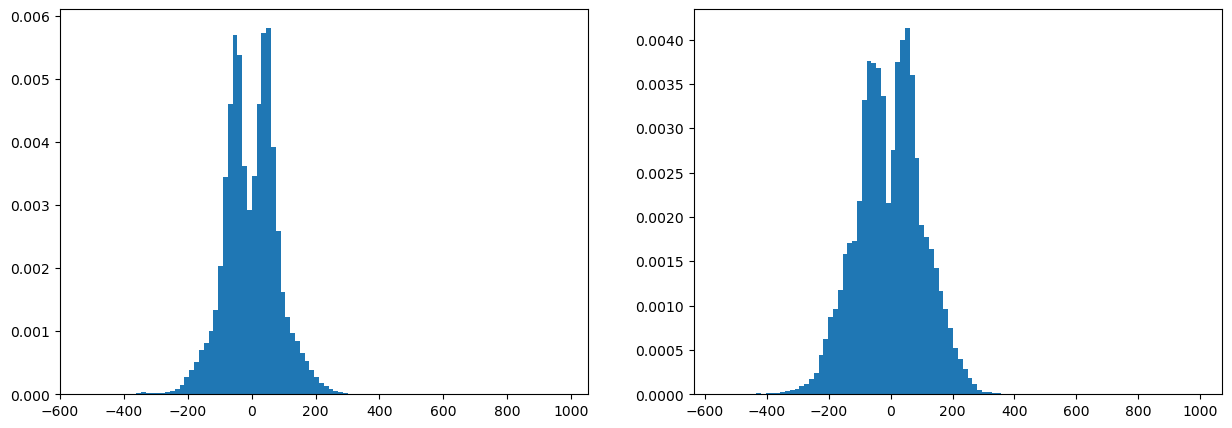

(78138, 6)   (78138, 12)
[-0.7787362  -0.8905415  -0.6589257   0.62962157  1.2157792   2.0017693 ]
[-1.8051884  -1.1725934  -1.6116775  -0.83215964 -0.85980433 -0.62431604
  0.60447246  1.161346    2.0017693   1.0519613   1.5645031   1.0671715 ]


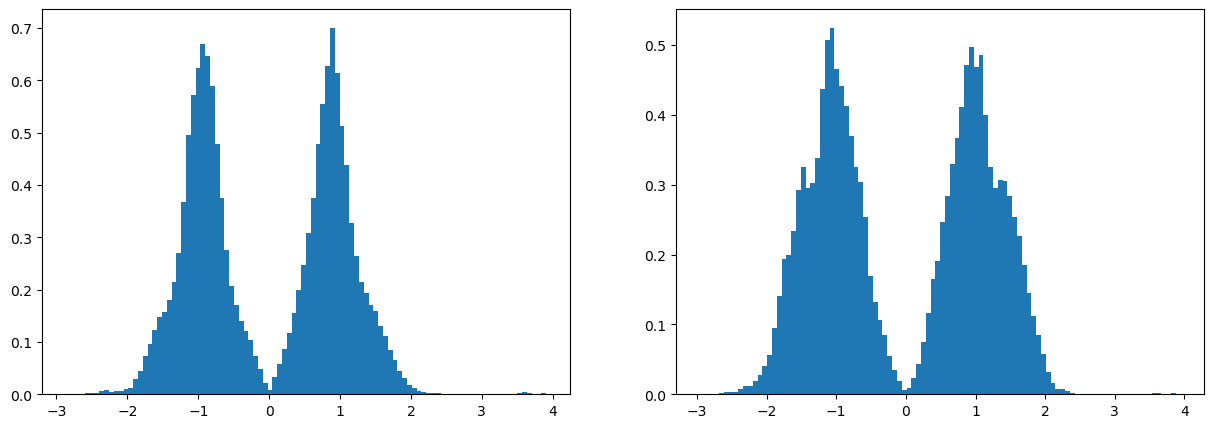

In [9]:
X_train_not_processed, y_train_not_processed = make_centred_LOB_snapshots(histograms, level=3)
print(X_train_not_processed.shape," ",y_train_not_processed.shape)
print(X_train_not_processed[0])
print(y_train_not_processed[0])
all_orders = X_train_not_processed.ravel()
all_orders_next = y_train_not_processed.ravel()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(all_orders, bins=100, density=True)
axes[1].hist(all_orders_next, bins=100, density=True)

plt.show()

S_t_dataset = normalization(X_train=X_train_not_processed,c=8)
X_t_delta_t_dataset = normalization(X_train=y_train_not_processed,c=8)
print(S_t_dataset.shape," ", X_t_delta_t_dataset.shape)
print(S_t_dataset[0])
print(X_t_delta_t_dataset[0])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(S_t_dataset.ravel(), bins=100, density=True)
axes[1].hist(X_t_delta_t_dataset.ravel(), bins=100, density=True)

plt.show()

### Marginal Distributions (Normalized)

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ve

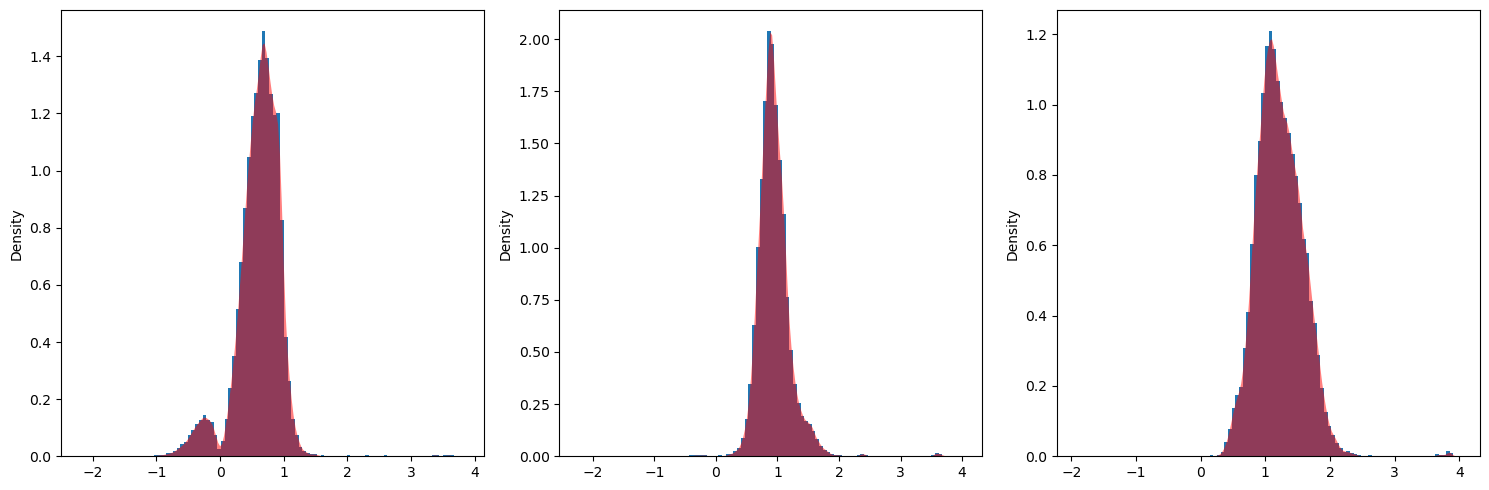

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ve

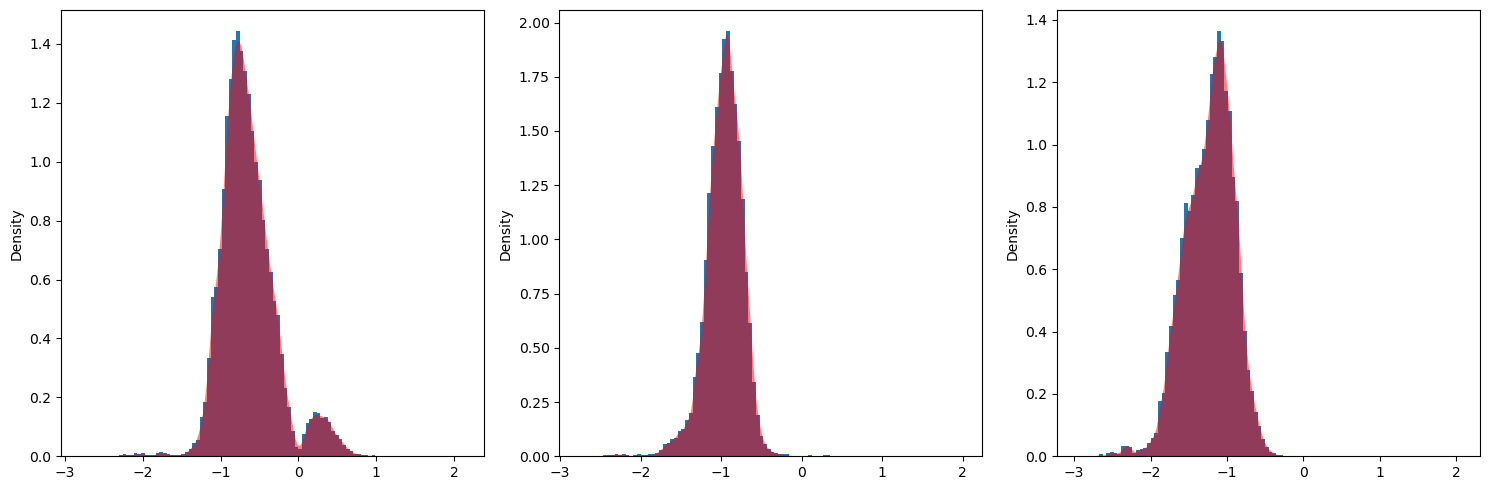

In [10]:
# asks_1 = X_t_delta_t_dataset[:, 6]
# asks_2 = X_t_delta_t_dataset[:, 7]
# asks_3 = X_t_delta_t_dataset[:, 8]

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# axes[0].hist(asks_1, bins=100, density=True)
# sns.kdeplot(asks_1, ax=axes[0], color='red', fill=True, linewidth=0, alpha=0.5)
# axes[1].hist(asks_2, bins=100, density=True)
# sns.kdeplot(asks_2, ax=axes[1], color='red', fill=True, linewidth=0, alpha=0.5)
# axes[2].hist(asks_3, bins=100, density=True)
# sns.kdeplot(asks_3, ax=axes[2], color='red', fill=True, linewidth=0, alpha=0.5)

# plt.tight_layout()
# plt.show()

# bids_1 = X_t_delta_t_dataset[:, 5]
# bids_2 = X_t_delta_t_dataset[:, 4]
# bids_3 = X_t_delta_t_dataset[:, 3]

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# axes[0].hist(bids_1, bins=100, density=True)
# sns.kdeplot(bids_1, ax=axes[0], color='red', fill=True, linewidth=0, alpha=0.5)
# axes[1].hist(bids_2, bins=100, density=True)
# sns.kdeplot(bids_2, ax=axes[1], color='red', fill=True, linewidth=0, alpha=0.5)
# axes[2].hist(bids_3, bins=100, density=True)
# sns.kdeplot(bids_3, ax=axes[2], color='red', fill=True, linewidth=0, alpha=0.5)

# plt.tight_layout()
# plt.show()



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace inf and -inf with NaN in your dataset columns
X_t_delta_t_dataset = np.where(np.isinf(X_t_delta_t_dataset), np.nan, X_t_delta_t_dataset)

# Assuming you've defined X_t_delta_t_dataset
asks_1 = X_t_delta_t_dataset[:, 6].astype(float)
asks_2 = X_t_delta_t_dataset[:, 7].astype(float)
asks_3 = X_t_delta_t_dataset[:, 8].astype(float)

# Remove or handle NaN values if necessary
# For example, drop NaN values for plotting
asks_1 = asks_1[~np.isnan(asks_1)]
asks_2 = asks_2[~np.isnan(asks_2)]
asks_3 = asks_3[~np.isnan(asks_3)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(asks_1, bins=100, density=True)
sns.kdeplot(asks_1, ax=axes[0], color='red', fill=True, linewidth=0, alpha=0.5)
axes[1].hist(asks_2, bins=100, density=True)
sns.kdeplot(asks_2, ax=axes[1], color='red', fill=True, linewidth=0, alpha=0.5)
axes[2].hist(asks_3, bins=100, density=True)
sns.kdeplot(asks_3, ax=axes[2], color='red', fill=True, linewidth=0, alpha=0.5)

plt.tight_layout()
plt.show()

# Repeat the process for bids
bids_1 = X_t_delta_t_dataset[:, 5].astype(float)
bids_2 = X_t_delta_t_dataset[:, 4].astype(float)
bids_3 = X_t_delta_t_dataset[:, 3].astype(float)

# Remove or handle NaN values if necessary
bids_1 = bids_1[~np.isnan(bids_1)]
bids_2 = bids_2[~np.isnan(bids_2)]
bids_3 = bids_3[~np.isnan(bids_3)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(bids_1, bins=100, density=True)
sns.kdeplot(bids_1, ax=axes[0], color='red', fill=True, linewidth=0, alpha=0.5)
axes[1].hist(bids_2, bins=100, density=True)
sns.kdeplot(bids_2, ax=axes[1], color='red', fill=True, linewidth=0, alpha=0.5)
axes[2].hist(bids_3, bins=100, density=True)
sns.kdeplot(bids_3, ax=axes[2], color='red', fill=True, linewidth=0, alpha=0.5)

plt.tight_layout()
plt.show()



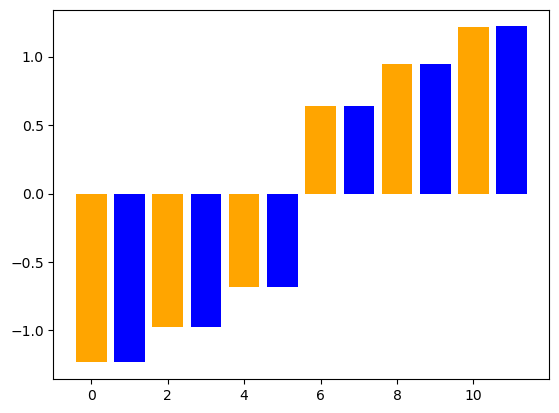

In [11]:
indices, interleaved_array = draw_avg_centre_comparison(X_t_delta_t_dataset, S_t_dataset, level = 3)
plt.bar(indices, interleaved_array, color=['orange', 'blue'] * (len(interleaved_array) // 2))
plt.show()

In [12]:
S_t_dataset_tensor = torch.tensor(S_t_dataset, dtype=torch.float32).to(device)
X_t_delta_t_dataset_tensor = torch.tensor(X_t_delta_t_dataset, dtype=torch.float32).to(device)
dataset = TensorDataset(X_t_delta_t_dataset_tensor, S_t_dataset_tensor)
data_loader = DataLoader(dataset, batch_size=500, shuffle=True)

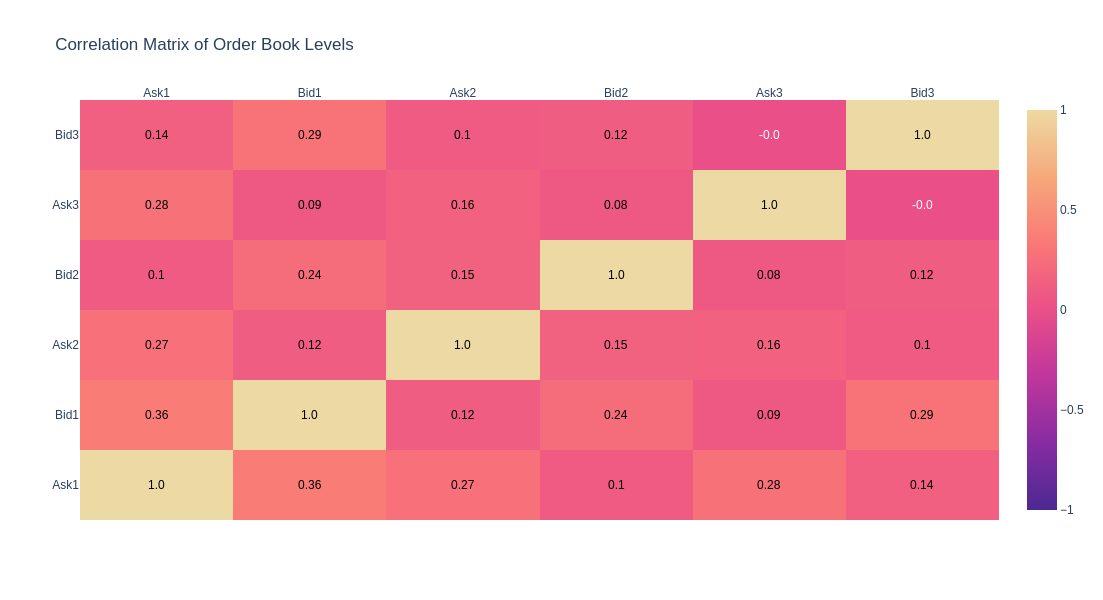

In [13]:
# import numpy as np
# import pandas as pd

# # First, select the relevant slices of the array for bid_1, bid_2, bid_3, ask_1, ask_2, and ask_3
# data = X_t_delta_t_dataset[:, [6, 5, 7, 4, 8, 3]]

# # Convert this data into a pandas DataFrame
# columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
# df = pd.DataFrame(data, columns=columns)
# df.dropna(inplace=True)     # Example: Drop rows with NaNs

# # Compute the correlation matrix
# correlation_matrix = df.corr()

# # Plotting the correlation matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True, vmin=-1, vmax=1)
# plt.title('Correlation Matrix of Order Book Levels')
# plt.show()


# Assuming X_t_delta_t_dataset is correctly defined earlier in your script
data = X_t_delta_t_dataset[:, [6, 5, 7, 4, 8, 3]]

# Convert this data into a pandas DataFrame
columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
df = pd.DataFrame(data, columns=columns)

# Ensure data types are numeric for correlation computation
df = df.apply(pd.to_numeric, errors='coerce')

# Compute the correlation matrix
correlation_matrix = df.corr()

# Reverse the order of rows in 'z' and 'annotation_text', and reverse the y-axis labels
z_reversed = correlation_matrix.to_numpy()[::-1]
annotation_text_reversed = correlation_matrix.round(2).to_numpy()[::-1]
y_reversed = correlation_matrix.columns.tolist()[::-1]

# Generate the heatmap
fig = ff.create_annotated_heatmap(
    z=correlation_matrix.to_numpy(),
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.columns.tolist(),
    annotation_text=correlation_matrix.round(2).to_numpy(),
    colorscale='agsunset',
    showscale=True,
    zmin=-1, # Set minimum of scale
    zmax=1  # Set maximum of scale
)

# Update layout to make it more readable
fig.update_layout(
    title='Correlation Matrix of Order Book Levels',
    xaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
    yaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
    width=600, 
    height=600,
)

fig.show()

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

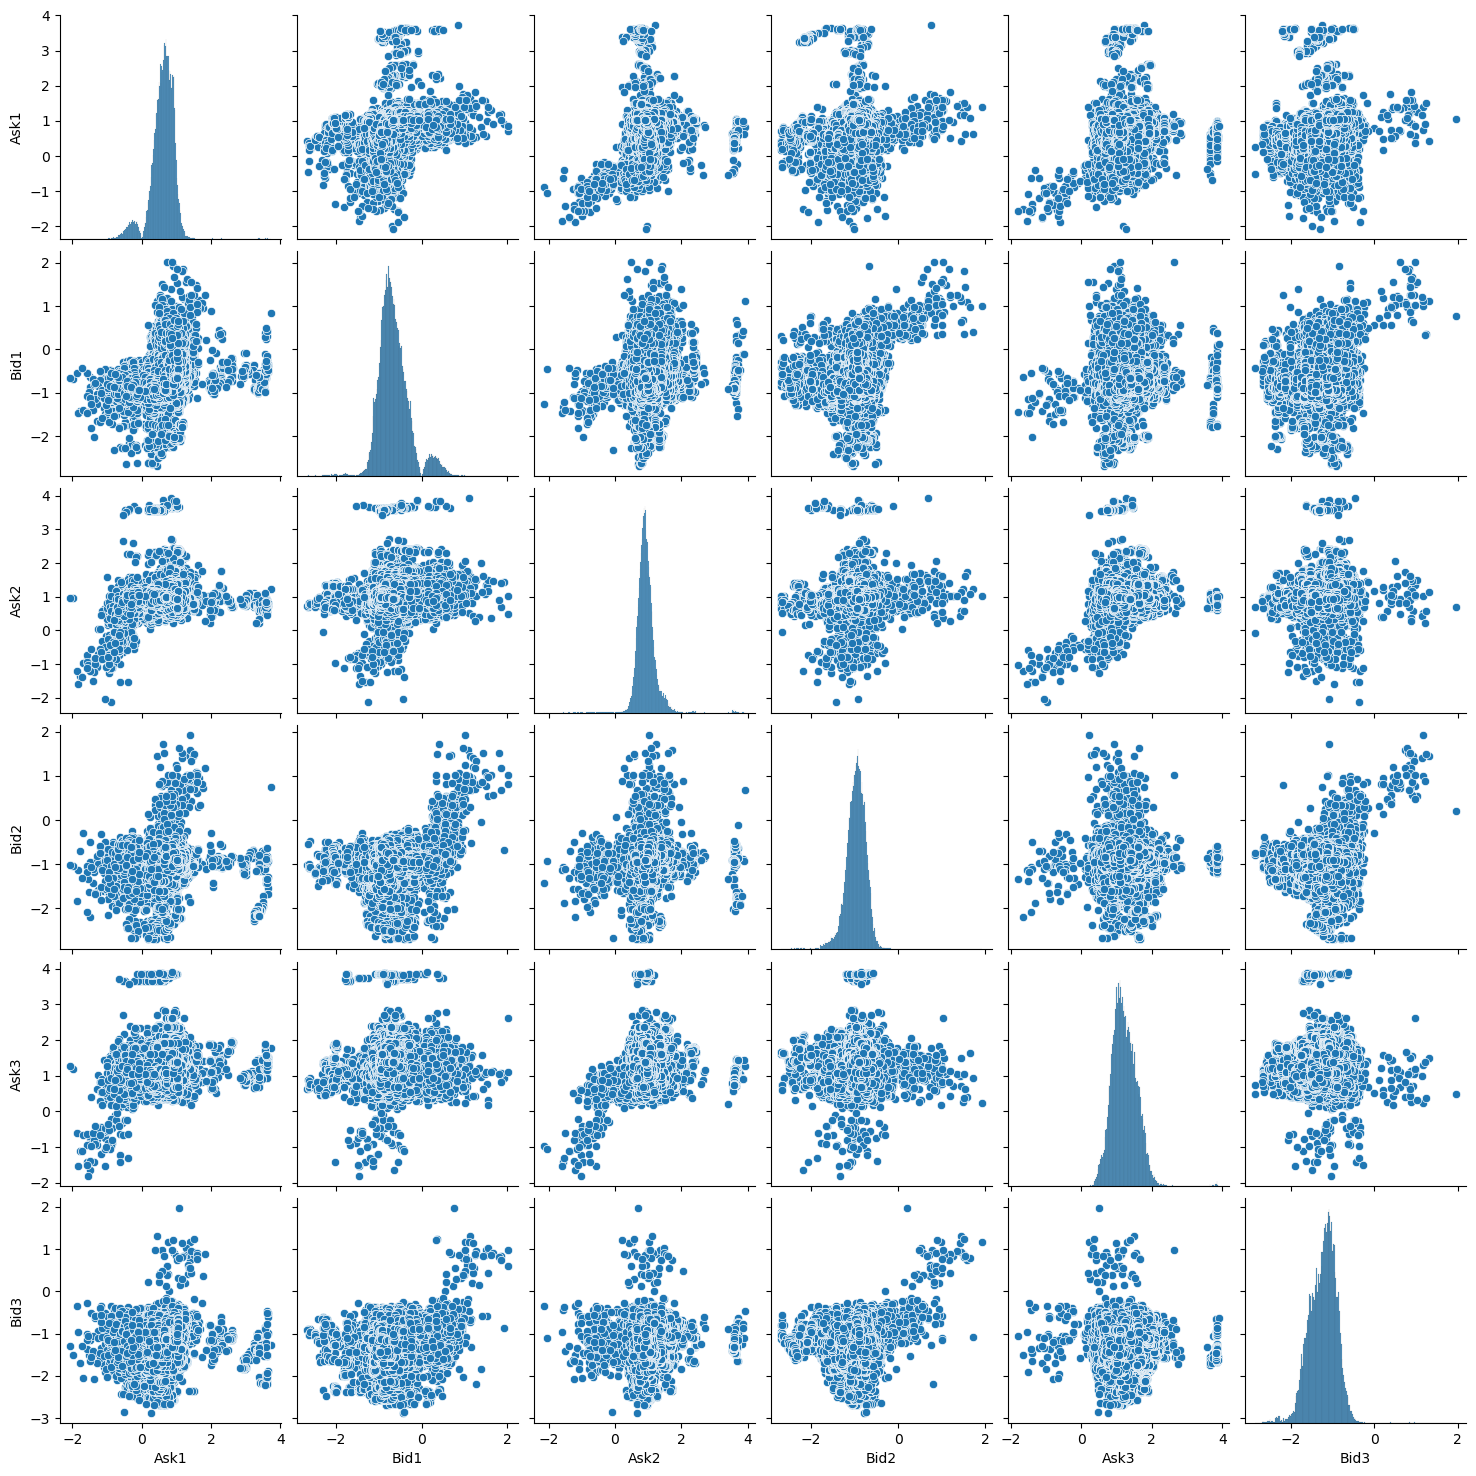

In [14]:
# First, select the relevant slices of the array for bid_1, bid_2, bid_3, ask_1, ask_2, and ask_3
data = X_t_delta_t_dataset[:, [6, 5, 7, 4, 8, 3]]

# Convert this data into a pandas DataFrame
columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
df = pd.DataFrame(data, columns=columns)

sns.pairplot(df)

## WGAN-GP Training

### Defining the Critic and Generator

In [15]:
class Generator(nn.Module):
    def __init__(self, latent_dim=6, n=6):
        super(Generator, self).__init__()
        self.h_11 = nn.Linear(latent_dim,32).to(device)
        self.h_12 = nn.Linear(n,32).to(device)
        self.h_21 = nn.Linear(32,32).to(device)
        self.h_22 = nn.Linear(32,32).to(device)
        self.h_32 = nn.Linear(64, 64).to(device)
        self.h_33 = nn.Linear(64, 12).to(device)
        
        self.h_34 = nn.Linear(6, 6).to(device)
        self.h_35 = nn.Linear(6, 6).to(device)
        
    def forward(self, Z_t, S_t):
        Z_t = Z_t.to(device)  # Move input tensor to the device
        S_t = S_t.to(device)  # Move input tensor to the device

        h_11_output = torch.relu(self.h_11(Z_t))
        h_21_output = torch.relu(self.h_21(h_11_output))
        
        h_12_output = torch.relu(self.h_12(S_t))
        h_22_output = torch.relu(self.h_22(h_12_output))
        
        # Concatenation
        h_31_output = torch.cat((h_21_output, h_22_output), dim=1)
        
        h_32_output = torch.relu(self.h_32(h_31_output))
        h_33_output = self.h_33(h_32_output)

        h_34_output = torch.relu(self.h_34(h_33_output[:, 3: 9]))
        h_35_output = self.h_35(h_34_output)
        concatenated_output = torch.cat((h_33_output[:,:3], h_35_output, h_33_output[:, 9:]), dim=1)
        return concatenated_output

'''
# Markovian Setting
class Critic(nn.Module):
    def __init__(self, n_1=12, n_2=6):
        super(Critic, self).__init__()
        self.h_11 = nn.Linear(n_1,32).to(device)
        self.h_12 = nn.Linear(n_2,32).to(device)
        self.h_21 = nn.Linear(32,32).to(device)
        self.h_22 = nn.Linear(32,32).to(device)
        self.h_32 = nn.Linear(64, 64).to(device)
        self.h_33 = nn.Linear(64, 1).to(device)

    def forward(self, X_t_delta_t, S_t):
        X_t_delta_t = X_t_delta_t.to(device)  # Move input tensor to the device
        S_t = S_t.to(device)  # Move input tensor to the device

        h_11_output = torch.relu(self.h_11(X_t_delta_t))
        h_21_output = torch.relu(self.h_21(h_11_output))
        
        h_12_output = torch.relu(self.h_12(S_t))
        h_22_output = torch.relu(self.h_22(h_12_output))
        
        # Concatenation
        h_31_output = torch.cat((h_21_output, h_22_output), dim=1)
        
        h_32_output = torch.relu(self.h_32(h_31_output))
        h_33_output = self.h_33(h_32_output)
        return h_33_output
'''


class Critic(nn.Module):
    def __init__(self, n_1=12, n_2=6):
        super(Critic, self).__init__()
        # Increasing the depth and width of the network
        self.model = nn.Sequential(
            nn.Linear(n_1 + n_2, 64).to(device),
            nn.LeakyReLU(0.2).to(device),
            nn.Linear(64, 128).to(device),
            nn.LeakyReLU(0.2).to(device),
            nn.Linear(128, 256).to(device),
            nn.LeakyReLU(0.2).to(device),
            nn.Dropout(0.3).to(device),
            nn.Linear(256, 1).to(device)
        )

    def forward(self, X_t_delta_t, S_t):
        X_t_delta_t = X_t_delta_t.to(device)  # Move input tensor to the device
        S_t = S_t.to(device)  # Move input tensor to the device        
        # Concatenation of inputs
        combined_input = torch.cat((X_t_delta_t, S_t), dim=1)
        validity = self.model(combined_input)
        return validity


In [23]:
# Define training hyperparameters
n_critic = 5
z_t_dim = 12
LAMBDA = 10
epochs = 100000

# Instantiate the generator and discriminator with device adaptation
generator = Generator(latent_dim=z_t_dim, n=6).to(device)
critic = Critic(n_1=12, n_2=6).to(device)

# Define the optimisers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0, 0.9))
optimizer_D = optim.Adam(critic.parameters(), lr=0.0001, betas=(0, 0.9))

avg_d_loss_list = []
avg_g_loss_list = []

### Defining the training loop

#### Tensorboard run location

In [ ]:
# Initialize SummaryWriter
writelocation = "runs/" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
writer = SummaryWriter(writelocation)
    

In [24]:
writer = SummaryWriter("runs/2024-02-15_18:34:54")

#### Tensorboard functions

In [25]:
def write_marginal_distributions_to_tensorboard(epoch, X_t_delta_t_generated):
    # Function to create and log a KDE plot
    def log_kde_plot(data, title, epoch, writer):
        plt.figure(figsize=(10, 6))
        plt.hist(data.cpu().numpy(), bins=100, density=True)
        sns.kdeplot(data.cpu().numpy(), color='red', fill=True, alpha=0.5)
        plt.title(title)
        # Save the plot to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close()
        buf.seek(0)
        # Use add_image to log the plot
        writer.add_image(title, plt.imread(buf), epoch, dataformats='HWC')
    # Indices for asks and bids might need adjustment based on dataset structure
    asks_bids_indices = {
        'Ask 1': 6,
        'Ask 2': 7,
        'Ask 3': 8,
        'Bid 1': 5,
        'Bid 2': 4,
        'Bid 3': 3,
    }

    for title, index in asks_bids_indices.items():
        data = X_t_delta_t_generated[:, index]
        log_kde_plot(data, title, epoch, writer)
        
        
# def write_covariance_matrix_of_generated_data_to_tensorboard(epoch, X_t_delta_t_generated):
#     best_k_ask_bids = X_t_delta_t_generated[:, [6, 5, 7, 4, 8, 3]].cpu().numpy()
#     columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
#     df = pd.DataFrame(best_k_ask_bids, columns=columns)
#     correlation_matrix = df.corr()
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True, vmin=-1, vmax=1)
#     plt.title('Correlation Matrix of Order Book Levels')
#     # Save the plot to a buffer
#     buf = io.BytesIO()
#     plt.savefig(buf, format='png')
#     plt.close()
#     buf.seek(0)
#     # Use add_image to log the plot
#     writer.add_image('Correlation Matrix of Order Book Levels', plt.imread(buf), epoch, dataformats='HWC')

def write_covariance_matrix_of_generated_data_to_tensorboard(epoch, X_t_delta_t_generated):
    data = X_t_delta_t_generated[:, [6, 5, 7, 4, 8, 3]].cpu().numpy()
    columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
    df = pd.DataFrame(data, columns=columns)
    df = df.apply(pd.to_numeric, errors='coerce')
    correlation_matrix = df.corr()

    fig = ff.create_annotated_heatmap(
        z=correlation_matrix.to_numpy(),
        x=correlation_matrix.columns.tolist(),
        y=correlation_matrix.columns.tolist()[::-1],  # Reverse y-axis labels for visual consistency
        annotation_text=correlation_matrix.round(2).to_numpy(),
        colorscale='agsunset',
        showscale=True,
        zmin=-1, 
        zmax=1
    )

    fig.update_layout(
        title='Correlation Matrix of Order Book Levels',
        xaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
        yaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns[::-1]),  # Ensure y-axis is reversed
        width=600, 
        height=600,
    )

    # Convert Plotly fig to PNG image using kaleido
    img_bytes = fig.to_image(format="png")

    # Use io.BytesIO as an in-memory file to read the image
    buf = io.BytesIO(img_bytes)

    # Log the image to TensorBoard
    from PIL import Image
    image = Image.open(buf)
    writer.add_image('Correlation Matrix of Order Book Levels', np.array(image), epoch, dataformats='HWC')
    
def write_avg_LOB_snapshot_to_tensorboard(epoch, X_t_delta_t_generated):
    X_t_delta_t_generated = X_t_delta_t_generated.cpu().numpy()
    indices, interleaved_array = draw_avg_centre_comparison(X_t_delta_t_generated, S_t_dataset, level = 3)
    plt.figure(figsize=(10, 8))
    plt.bar(indices, interleaved_array, color=['orange', 'blue'] * (len(interleaved_array) // 2))
    plt.title('Average LOB shape real and fake')
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    writer.add_image('Average LOB shape real(orange) and fake(blue)', plt.imread(buf), epoch, dataformats='HWC')
    
def write_pair_scatter_plot_to_tensorboard(epoch, X_t_delta_t_generated):
    best_k_ask_bids = X_t_delta_t_generated[:, [6, 5, 7, 4, 8, 3]].cpu().numpy()
    columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
    df = pd.DataFrame(best_k_ask_bids, columns=columns)
    plt.figure()
    sns.pairplot(df)
    plt.title('Scatter plot of Orderbook Levels')
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    writer.add_image('Scatter plot of Orderbook Levels', plt.imread(buf), epoch, dataformats='HWC')
    
def write_metrics_to_tensorboard(epoch):
    with torch.no_grad():
        z_t = torch.randn(S_t_dataset.shape[0], z_t_dim)
        X_t_delta_t_generated = generator(z_t, S_t_dataset_tensor)
    write_marginal_distributions_to_tensorboard(epoch, X_t_delta_t_generated)
    write_covariance_matrix_of_generated_data_to_tensorboard(epoch, X_t_delta_t_generated)
    write_avg_LOB_snapshot_to_tensorboard(epoch, X_t_delta_t_generated)
    write_pair_scatter_plot_to_tensorboard(epoch, X_t_delta_t_generated)

        
def write_loss_functions_to_tensorboard(avg_d_loss, avg_g_loss,epoch):
    writer.add_scalar('Loss/Discriminator', avg_d_loss, epoch)
    writer.add_scalar('Loss/Generator', avg_g_loss, epoch)

#### Gradient Penalty

In [26]:
def gradient_penalty(C, real_samples, fake_samples, batch_S_t):
    batch_size = real_samples.size(0)
    # Ensure alpha is shaped correctly for broadcasting
    alpha = torch.rand(batch_size, 1, device=device)
    alpha = alpha.expand(batch_size, real_samples.nelement() // batch_size).contiguous().view(batch_size, -1)

    # Calculate interpolates
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = C(interpolates, batch_S_t)
    
    fake = Variable(torch.Tensor(batch_size , 1).fill_(1.0), requires_grad=False).to(device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=fake,
                     create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Flatten the gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

#### Training Loop of WGAN with Gradient Penalty

In [27]:
start_epoch = 0

In [30]:
# Define variables to track progress
avg_d_loss = 0
avg_g_loss = 0
n_batches = len(data_loader)

for epoch in range(start_epoch, epochs):
    
    # Variables per epoch
    total_d_loss_epoch = 0
    total_g_loss_epoch = 0
    
    for i, (batch_X_t_delta_t, batch_S_t) in enumerate(data_loader):
        batch_size = batch_S_t.shape[0]
        
        batch_S_t = batch_S_t.to(device)
        batch_X_t_delta_t = batch_X_t_delta_t.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        total_d_loss_batch = 0
        for _ in range(n_critic):  # Update the discriminator n_critic times
            optimizer_D.zero_grad()

            # Sample noise as generator input
            batch_Z_t = torch.randn(batch_size, z_t_dim, device=device)  # Ensure noise_dim matches generator input

            # Generate a batch of images
            batch_X_t_delta_t_generated = generator(batch_Z_t, batch_S_t)

            # Real images
            real_validity = critic(batch_X_t_delta_t, batch_S_t)
            # Fake images
            fake_validity = critic(batch_X_t_delta_t_generated, batch_S_t)
            # Gradient penalty
            gp = gradient_penalty(critic, batch_X_t_delta_t.data, batch_X_t_delta_t_generated.data, batch_S_t.data)
            
            # Wasserstein GAN loss w/ gradient penalty
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA * gp

            d_loss.backward()
            optimizer_D.step()
            total_d_loss_batch += d_loss.item()
            
        d_loss_batch = total_d_loss_batch / n_critic
        total_d_loss_epoch += d_loss_batch # Average over the n_critic updates
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Resample noise (optional but often leads to better training stability)
        batch_Z_t = torch.randn(batch_size, z_t_dim, device=device)

        # Generate a batch of images
        batch_X_t_delta_t_generated = generator(batch_Z_t, batch_S_t)
        fake_validity = critic(batch_X_t_delta_t_generated, batch_S_t)
        # Loss measures generator's ability to fool the discriminator
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()
        total_g_loss_epoch += g_loss.item()

    # Prints average loss per epoch
    avg_d_loss = total_d_loss_epoch / n_batches
    avg_g_loss = total_g_loss_epoch / n_batches
    avg_d_loss_list.append(avg_d_loss)
    avg_g_loss_list.append(avg_g_loss)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] completed. Avg D Loss: {avg_d_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")
        
    if (epoch + 1) % 100 == 0:
        write_metrics_to_tensorboard(epoch)
        
    write_loss_functions_to_tensorboard(avg_d_loss, avg_g_loss,epoch)
    # Resets average losses for the next epoch
    avg_d_loss = 0
    avg_g_loss = 0

# Close the writer after the training loop
writer.close()    

Epoch [10000/100000] completed. Avg D Loss: -0.0475, Avg G Loss: -15.5222


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [10020/100000] completed. Avg D Loss: -0.0408, Avg G Loss: -14.1801
Epoch [10040/100000] completed. Avg D Loss: -0.0394, Avg G Loss: -15.1273
Epoch [10060/100000] completed. Avg D Loss: -0.0399, Avg G Loss: -17.5671
Epoch [10080/100000] completed. Avg D Loss: -0.0504, Avg G Loss: -18.2805
Epoch [10100/100000] completed. Avg D Loss: -0.0502, Avg G Loss: -18.2034


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [10120/100000] completed. Avg D Loss: -0.0525, Avg G Loss: -18.3508
Epoch [10140/100000] completed. Avg D Loss: -0.0477, Avg G Loss: -19.2126
Epoch [10160/100000] completed. Avg D Loss: -0.0510, Avg G Loss: -19.6164
Epoch [10180/100000] completed. Avg D Loss: -0.0542, Avg G Loss: -20.9393
Epoch [10200/100000] completed. Avg D Loss: -0.0528, Avg G Loss: -22.5908


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [10220/100000] completed. Avg D Loss: -0.0521, Avg G Loss: -20.8121
Epoch [10240/100000] completed. Avg D Loss: -0.0587, Avg G Loss: -18.7098
Epoch [10260/100000] completed. Avg D Loss: -0.0619, Avg G Loss: -22.4634
Epoch [10280/100000] completed. Avg D Loss: -0.0295, Avg G Loss: -19.1998
Epoch [10300/100000] completed. Avg D Loss: -0.0247, Avg G Loss: -22.7632


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [10320/100000] completed. Avg D Loss: -0.0483, Avg G Loss: -23.0294
Epoch [10340/100000] completed. Avg D Loss: -0.0503, Avg G Loss: -24.7321
Epoch [10360/100000] completed. Avg D Loss: -0.0402, Avg G Loss: -24.7847
Epoch [10380/100000] completed. Avg D Loss: -0.0406, Avg G Loss: -24.5499
Epoch [10400/100000] completed. Avg D Loss: -0.0482, Avg G Loss: -24.4821


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [10420/100000] completed. Avg D Loss: -0.0616, Avg G Loss: -24.4235
Epoch [10440/100000] completed. Avg D Loss: -0.0360, Avg G Loss: -26.6182
Epoch [10460/100000] completed. Avg D Loss: -0.0543, Avg G Loss: -26.9980
Epoch [10480/100000] completed. Avg D Loss: -0.0400, Avg G Loss: -25.5685
Epoch [10500/100000] completed. Avg D Loss: -0.0425, Avg G Loss: -25.5545


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [10520/100000] completed. Avg D Loss: -0.0637, Avg G Loss: -25.1083
Epoch [10540/100000] completed. Avg D Loss: -0.0401, Avg G Loss: -23.4339
Epoch [10560/100000] completed. Avg D Loss: -0.0607, Avg G Loss: -22.3715
Epoch [10580/100000] completed. Avg D Loss: -0.0513, Avg G Loss: -23.2648
Epoch [10600/100000] completed. Avg D Loss: -0.0449, Avg G Loss: -25.6425


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [10620/100000] completed. Avg D Loss: -0.0475, Avg G Loss: -20.5173
Epoch [10640/100000] completed. Avg D Loss: -0.0361, Avg G Loss: -22.6869
Epoch [10660/100000] completed. Avg D Loss: -0.0548, Avg G Loss: -23.5559
Epoch [10680/100000] completed. Avg D Loss: -0.0409, Avg G Loss: -25.9831
Epoch [10700/100000] completed. Avg D Loss: -0.0527, Avg G Loss: -28.0803


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [10720/100000] completed. Avg D Loss: -0.0365, Avg G Loss: -25.4361
Epoch [10740/100000] completed. Avg D Loss: -0.0489, Avg G Loss: -20.6404
Epoch [10760/100000] completed. Avg D Loss: -0.0445, Avg G Loss: -21.5259
Epoch [10780/100000] completed. Avg D Loss: 0.0192, Avg G Loss: -3.0568
Epoch [10800/100000] completed. Avg D Loss: 0.0101, Avg G Loss: -9.2863


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [10820/100000] completed. Avg D Loss: 0.0030, Avg G Loss: -4.8262
Epoch [10840/100000] completed. Avg D Loss: 0.0022, Avg G Loss: -12.6570
Epoch [10860/100000] completed. Avg D Loss: 0.0033, Avg G Loss: -11.5297
Epoch [10880/100000] completed. Avg D Loss: -0.0090, Avg G Loss: -15.2333
Epoch [10900/100000] completed. Avg D Loss: -0.0385, Avg G Loss: -17.2992


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [10920/100000] completed. Avg D Loss: 0.0090, Avg G Loss: -7.4492
Epoch [10940/100000] completed. Avg D Loss: 0.0285, Avg G Loss: -11.2841
Epoch [10960/100000] completed. Avg D Loss: 0.0179, Avg G Loss: -17.4943
Epoch [10980/100000] completed. Avg D Loss: -0.0120, Avg G Loss: -23.5810
Epoch [11000/100000] completed. Avg D Loss: -0.0075, Avg G Loss: -19.9882


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [11020/100000] completed. Avg D Loss: 0.0025, Avg G Loss: -9.6197
Epoch [11040/100000] completed. Avg D Loss: -0.0155, Avg G Loss: -6.2119
Epoch [11060/100000] completed. Avg D Loss: 0.0118, Avg G Loss: -3.9344
Epoch [11080/100000] completed. Avg D Loss: 0.0267, Avg G Loss: 1.9891
Epoch [11100/100000] completed. Avg D Loss: 0.0038, Avg G Loss: -11.4012


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [11120/100000] completed. Avg D Loss: -0.0332, Avg G Loss: -11.1192
Epoch [11140/100000] completed. Avg D Loss: -0.0525, Avg G Loss: -11.6282
Epoch [11160/100000] completed. Avg D Loss: -0.0257, Avg G Loss: -20.3735
Epoch [11180/100000] completed. Avg D Loss: 0.0106, Avg G Loss: -21.6029
Epoch [11200/100000] completed. Avg D Loss: -0.0026, Avg G Loss: -20.9849


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [11220/100000] completed. Avg D Loss: -0.0451, Avg G Loss: -15.8816
Epoch [11240/100000] completed. Avg D Loss: -0.0213, Avg G Loss: -18.7598
Epoch [11260/100000] completed. Avg D Loss: 0.0052, Avg G Loss: -21.6166
Epoch [11280/100000] completed. Avg D Loss: -0.0368, Avg G Loss: -28.4307
Epoch [11300/100000] completed. Avg D Loss: -0.0061, Avg G Loss: -28.5842


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [11320/100000] completed. Avg D Loss: -0.0396, Avg G Loss: -16.4097
Epoch [11340/100000] completed. Avg D Loss: -0.0361, Avg G Loss: -18.3600
Epoch [11360/100000] completed. Avg D Loss: -0.0524, Avg G Loss: -15.9143
Epoch [11380/100000] completed. Avg D Loss: -0.0271, Avg G Loss: -12.9495
Epoch [11400/100000] completed. Avg D Loss: -0.0286, Avg G Loss: -10.0319


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [11420/100000] completed. Avg D Loss: 0.0158, Avg G Loss: -27.8636
Epoch [11440/100000] completed. Avg D Loss: -0.0121, Avg G Loss: -23.6502
Epoch [11460/100000] completed. Avg D Loss: -0.0256, Avg G Loss: -21.3017
Epoch [11480/100000] completed. Avg D Loss: -0.0184, Avg G Loss: -21.6627
Epoch [11500/100000] completed. Avg D Loss: -0.0463, Avg G Loss: -20.7361


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [11520/100000] completed. Avg D Loss: -0.0252, Avg G Loss: -11.6892
Epoch [11540/100000] completed. Avg D Loss: -0.0039, Avg G Loss: -9.5386
Epoch [11560/100000] completed. Avg D Loss: -0.0210, Avg G Loss: -7.1574
Epoch [11580/100000] completed. Avg D Loss: -0.0057, Avg G Loss: -12.5829
Epoch [11600/100000] completed. Avg D Loss: -0.0399, Avg G Loss: -19.8109


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [11620/100000] completed. Avg D Loss: -0.0597, Avg G Loss: -24.9927
Epoch [11640/100000] completed. Avg D Loss: 0.0085, Avg G Loss: -21.8772
Epoch [11660/100000] completed. Avg D Loss: -0.0506, Avg G Loss: -21.8866
Epoch [11680/100000] completed. Avg D Loss: -0.0275, Avg G Loss: -19.8605
Epoch [11700/100000] completed. Avg D Loss: -0.0209, Avg G Loss: -26.8323


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [11720/100000] completed. Avg D Loss: -0.0475, Avg G Loss: -21.6898
Epoch [11740/100000] completed. Avg D Loss: -0.0287, Avg G Loss: -12.4959
Epoch [11760/100000] completed. Avg D Loss: -0.0356, Avg G Loss: -7.9621
Epoch [11780/100000] completed. Avg D Loss: -0.0399, Avg G Loss: 1.5706
Epoch [11800/100000] completed. Avg D Loss: -0.0173, Avg G Loss: -20.2885


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [11820/100000] completed. Avg D Loss: -0.0265, Avg G Loss: -15.2446
Epoch [11840/100000] completed. Avg D Loss: -0.0471, Avg G Loss: -8.5832
Epoch [11860/100000] completed. Avg D Loss: -0.0266, Avg G Loss: -13.7146
Epoch [11880/100000] completed. Avg D Loss: 0.0035, Avg G Loss: -13.2864
Epoch [11900/100000] completed. Avg D Loss: -0.0250, Avg G Loss: -13.8397


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [11920/100000] completed. Avg D Loss: -0.0439, Avg G Loss: -15.1861
Epoch [11940/100000] completed. Avg D Loss: -0.0204, Avg G Loss: -2.5021
Epoch [11960/100000] completed. Avg D Loss: -0.0354, Avg G Loss: -12.5307
Epoch [11980/100000] completed. Avg D Loss: -0.0080, Avg G Loss: -10.0125
Epoch [12000/100000] completed. Avg D Loss: -0.0519, Avg G Loss: -9.5654


/tmp/ipykernel_59718/830192908.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/tmp/ipykernel_59718/830192908.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplo

Epoch [12020/100000] completed. Avg D Loss: 0.0006, Avg G Loss: -11.0070
Epoch [12040/100000] completed. Avg D Loss: 0.0069, Avg G Loss: -7.1358
Epoch [12060/100000] completed. Avg D Loss: -0.0269, Avg G Loss: -12.6285
Epoch [12080/100000] completed. Avg D Loss: -0.0230, Avg G Loss: -13.5799
Epoch [12100/100000] completed. Avg D Loss: -0.0350, Avg G Loss: -7.0511


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [12120/100000] completed. Avg D Loss: -0.0141, Avg G Loss: -13.5572
Epoch [12140/100000] completed. Avg D Loss: -0.0483, Avg G Loss: -16.3447
Epoch [12160/100000] completed. Avg D Loss: -0.0456, Avg G Loss: -10.1724
Epoch [12180/100000] completed. Avg D Loss: -0.0338, Avg G Loss: -13.0691
Epoch [12200/100000] completed. Avg D Loss: -0.0426, Avg G Loss: -16.1523


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [12220/100000] completed. Avg D Loss: -0.0241, Avg G Loss: -15.0064
Epoch [12240/100000] completed. Avg D Loss: -0.0489, Avg G Loss: -16.0502
Epoch [12260/100000] completed. Avg D Loss: -0.0411, Avg G Loss: -7.6948
Epoch [12280/100000] completed. Avg D Loss: -0.0295, Avg G Loss: -5.4794
Epoch [12300/100000] completed. Avg D Loss: -0.0050, Avg G Loss: 2.1243


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [12320/100000] completed. Avg D Loss: -0.0210, Avg G Loss: 2.5957
Epoch [12340/100000] completed. Avg D Loss: -0.0395, Avg G Loss: -3.3805
Epoch [12360/100000] completed. Avg D Loss: -0.0227, Avg G Loss: -8.3433
Epoch [12380/100000] completed. Avg D Loss: -0.0252, Avg G Loss: -24.4920
Epoch [12400/100000] completed. Avg D Loss: -0.0154, Avg G Loss: -19.8572


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [12420/100000] completed. Avg D Loss: -0.0309, Avg G Loss: -22.2673
Epoch [12440/100000] completed. Avg D Loss: -0.0413, Avg G Loss: -15.3674
Epoch [12460/100000] completed. Avg D Loss: 0.0038, Avg G Loss: -16.1875
Epoch [12480/100000] completed. Avg D Loss: -0.0325, Avg G Loss: -11.5969
Epoch [12500/100000] completed. Avg D Loss: -0.0034, Avg G Loss: -13.5118


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [12520/100000] completed. Avg D Loss: -0.0469, Avg G Loss: -8.6354
Epoch [12540/100000] completed. Avg D Loss: -0.0306, Avg G Loss: -12.6714
Epoch [12560/100000] completed. Avg D Loss: -0.0329, Avg G Loss: -17.4616
Epoch [12580/100000] completed. Avg D Loss: -0.0508, Avg G Loss: -21.7216
Epoch [12600/100000] completed. Avg D Loss: -0.0457, Avg G Loss: -20.2460


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [12620/100000] completed. Avg D Loss: -0.0421, Avg G Loss: -15.9408
Epoch [12640/100000] completed. Avg D Loss: -0.0606, Avg G Loss: -22.1097
Epoch [12660/100000] completed. Avg D Loss: -0.0305, Avg G Loss: -33.3943
Epoch [12680/100000] completed. Avg D Loss: -0.0548, Avg G Loss: -38.7872
Epoch [12700/100000] completed. Avg D Loss: -0.0539, Avg G Loss: -34.3236


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [12720/100000] completed. Avg D Loss: -0.0361, Avg G Loss: -32.2182
Epoch [12740/100000] completed. Avg D Loss: -0.0518, Avg G Loss: -25.9629
Epoch [12760/100000] completed. Avg D Loss: -0.0154, Avg G Loss: -28.2080
Epoch [12780/100000] completed. Avg D Loss: -0.0263, Avg G Loss: -29.0799
Epoch [12800/100000] completed. Avg D Loss: -0.0345, Avg G Loss: -18.5694


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [12820/100000] completed. Avg D Loss: -0.0161, Avg G Loss: -14.1958
Epoch [12840/100000] completed. Avg D Loss: -0.0389, Avg G Loss: -12.3896
Epoch [12860/100000] completed. Avg D Loss: -0.0337, Avg G Loss: -8.9254
Epoch [12880/100000] completed. Avg D Loss: -0.0129, Avg G Loss: -11.4342
Epoch [12900/100000] completed. Avg D Loss: -0.0403, Avg G Loss: -5.2231


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [12920/100000] completed. Avg D Loss: -0.0463, Avg G Loss: -17.1972
Epoch [12940/100000] completed. Avg D Loss: -0.0407, Avg G Loss: -13.7380
Epoch [12960/100000] completed. Avg D Loss: -0.0503, Avg G Loss: -16.4608
Epoch [12980/100000] completed. Avg D Loss: -0.0322, Avg G Loss: -19.5395
Epoch [13000/100000] completed. Avg D Loss: -0.0415, Avg G Loss: -19.1409


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [13020/100000] completed. Avg D Loss: -0.0275, Avg G Loss: -20.5919
Epoch [13040/100000] completed. Avg D Loss: -0.0212, Avg G Loss: -11.0571
Epoch [13060/100000] completed. Avg D Loss: -0.0365, Avg G Loss: -16.8140
Epoch [13080/100000] completed. Avg D Loss: -0.0609, Avg G Loss: -18.2871
Epoch [13100/100000] completed. Avg D Loss: -0.0561, Avg G Loss: -11.7727


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [13120/100000] completed. Avg D Loss: -0.0489, Avg G Loss: -6.3814
Epoch [13140/100000] completed. Avg D Loss: -0.0518, Avg G Loss: -0.9825
Epoch [13160/100000] completed. Avg D Loss: -0.0311, Avg G Loss: -11.3473
Epoch [13180/100000] completed. Avg D Loss: -0.0266, Avg G Loss: -14.0606
Epoch [13200/100000] completed. Avg D Loss: -0.0428, Avg G Loss: -16.9293


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [13220/100000] completed. Avg D Loss: -0.0055, Avg G Loss: -18.7041
Epoch [13240/100000] completed. Avg D Loss: -0.0307, Avg G Loss: -14.5614
Epoch [13260/100000] completed. Avg D Loss: -0.0038, Avg G Loss: -9.6600
Epoch [13280/100000] completed. Avg D Loss: -0.0656, Avg G Loss: -6.5831
Epoch [13300/100000] completed. Avg D Loss: -0.0152, Avg G Loss: -13.7701


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [13320/100000] completed. Avg D Loss: -0.0297, Avg G Loss: -16.6919
Epoch [13340/100000] completed. Avg D Loss: -0.0253, Avg G Loss: -13.3253
Epoch [13360/100000] completed. Avg D Loss: -0.0603, Avg G Loss: -18.2601
Epoch [13380/100000] completed. Avg D Loss: -0.0233, Avg G Loss: -21.7545
Epoch [13400/100000] completed. Avg D Loss: -0.0603, Avg G Loss: -18.3217


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [13420/100000] completed. Avg D Loss: -0.0186, Avg G Loss: -15.0864
Epoch [13440/100000] completed. Avg D Loss: -0.0399, Avg G Loss: -24.0551
Epoch [13460/100000] completed. Avg D Loss: -0.0459, Avg G Loss: -20.0086
Epoch [13480/100000] completed. Avg D Loss: -0.0629, Avg G Loss: -22.5006
Epoch [13500/100000] completed. Avg D Loss: -0.0418, Avg G Loss: -21.7719


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [13520/100000] completed. Avg D Loss: -0.0321, Avg G Loss: -21.8723
Epoch [13540/100000] completed. Avg D Loss: -0.0345, Avg G Loss: -22.7734
Epoch [13560/100000] completed. Avg D Loss: -0.0556, Avg G Loss: -21.9481
Epoch [13580/100000] completed. Avg D Loss: -0.0642, Avg G Loss: -17.9482
Epoch [13600/100000] completed. Avg D Loss: -0.0222, Avg G Loss: -17.1834


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [13620/100000] completed. Avg D Loss: -0.0425, Avg G Loss: -19.2328
Epoch [13640/100000] completed. Avg D Loss: -0.0355, Avg G Loss: -19.1555
Epoch [13660/100000] completed. Avg D Loss: -0.0513, Avg G Loss: -16.3172
Epoch [13680/100000] completed. Avg D Loss: -0.0382, Avg G Loss: -13.8115
Epoch [13700/100000] completed. Avg D Loss: -0.0396, Avg G Loss: -16.6832


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [13720/100000] completed. Avg D Loss: -0.0195, Avg G Loss: -16.8500
Epoch [13740/100000] completed. Avg D Loss: -0.0540, Avg G Loss: -15.6879
Epoch [13760/100000] completed. Avg D Loss: -0.0424, Avg G Loss: -14.4780
Epoch [13780/100000] completed. Avg D Loss: -0.0525, Avg G Loss: -14.7113
Epoch [13800/100000] completed. Avg D Loss: -0.0507, Avg G Loss: -17.6671


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [13820/100000] completed. Avg D Loss: -0.0237, Avg G Loss: -10.8225
Epoch [13840/100000] completed. Avg D Loss: -0.0553, Avg G Loss: -9.4483
Epoch [13860/100000] completed. Avg D Loss: -0.0557, Avg G Loss: -15.3630
Epoch [13880/100000] completed. Avg D Loss: -0.0437, Avg G Loss: -5.4837
Epoch [13900/100000] completed. Avg D Loss: -0.0585, Avg G Loss: -0.4605


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [13920/100000] completed. Avg D Loss: -0.0268, Avg G Loss: -10.5829
Epoch [13940/100000] completed. Avg D Loss: -0.0698, Avg G Loss: -12.3016
Epoch [13960/100000] completed. Avg D Loss: -0.0081, Avg G Loss: -8.2541
Epoch [13980/100000] completed. Avg D Loss: -0.0347, Avg G Loss: -11.6095
Epoch [14000/100000] completed. Avg D Loss: -0.0521, Avg G Loss: -18.0045


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [14020/100000] completed. Avg D Loss: -0.0343, Avg G Loss: -21.0478
Epoch [14040/100000] completed. Avg D Loss: -0.0014, Avg G Loss: -18.7141
Epoch [14060/100000] completed. Avg D Loss: -0.0360, Avg G Loss: -22.8787
Epoch [14080/100000] completed. Avg D Loss: -0.0388, Avg G Loss: -14.7763
Epoch [14100/100000] completed. Avg D Loss: -0.0516, Avg G Loss: -14.5416


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [14120/100000] completed. Avg D Loss: -0.0243, Avg G Loss: -6.3538
Epoch [14140/100000] completed. Avg D Loss: -0.0375, Avg G Loss: -5.8820
Epoch [14160/100000] completed. Avg D Loss: -0.0524, Avg G Loss: -0.6845
Epoch [14180/100000] completed. Avg D Loss: -0.0513, Avg G Loss: -12.2469
Epoch [14200/100000] completed. Avg D Loss: -0.0580, Avg G Loss: -6.6139


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [14220/100000] completed. Avg D Loss: -0.0668, Avg G Loss: -8.7535
Epoch [14240/100000] completed. Avg D Loss: -0.0467, Avg G Loss: -9.9012
Epoch [14260/100000] completed. Avg D Loss: -0.0329, Avg G Loss: -9.5494
Epoch [14280/100000] completed. Avg D Loss: -0.0471, Avg G Loss: -14.1410
Epoch [14300/100000] completed. Avg D Loss: -0.0800, Avg G Loss: -11.4672


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [14320/100000] completed. Avg D Loss: -0.0391, Avg G Loss: -14.8967
Epoch [14340/100000] completed. Avg D Loss: -0.0293, Avg G Loss: -13.1665
Epoch [14360/100000] completed. Avg D Loss: -0.0179, Avg G Loss: -6.5636
Epoch [14380/100000] completed. Avg D Loss: -0.0323, Avg G Loss: -11.1419
Epoch [14400/100000] completed. Avg D Loss: -0.0505, Avg G Loss: -11.3516


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [14420/100000] completed. Avg D Loss: -0.0524, Avg G Loss: -3.3967
Epoch [14440/100000] completed. Avg D Loss: -0.0491, Avg G Loss: -8.7558
Epoch [14460/100000] completed. Avg D Loss: -0.0412, Avg G Loss: -12.3095
Epoch [14480/100000] completed. Avg D Loss: -0.0352, Avg G Loss: -14.4290
Epoch [14500/100000] completed. Avg D Loss: -0.0268, Avg G Loss: -22.0796


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [14520/100000] completed. Avg D Loss: -0.0168, Avg G Loss: -15.5068
Epoch [14540/100000] completed. Avg D Loss: -0.0699, Avg G Loss: -20.8907
Epoch [14560/100000] completed. Avg D Loss: -0.0535, Avg G Loss: -22.1396
Epoch [14580/100000] completed. Avg D Loss: -0.0361, Avg G Loss: -19.7137
Epoch [14600/100000] completed. Avg D Loss: -0.0515, Avg G Loss: -19.8266


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [14620/100000] completed. Avg D Loss: -0.0207, Avg G Loss: -24.3980
Epoch [14640/100000] completed. Avg D Loss: -0.0638, Avg G Loss: -15.8219
Epoch [14660/100000] completed. Avg D Loss: -0.0107, Avg G Loss: -9.7907
Epoch [14680/100000] completed. Avg D Loss: -0.0299, Avg G Loss: -15.0816
Epoch [14700/100000] completed. Avg D Loss: -0.0535, Avg G Loss: -14.2281


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [14720/100000] completed. Avg D Loss: 0.0055, Avg G Loss: -16.6237
Epoch [14740/100000] completed. Avg D Loss: -0.0628, Avg G Loss: -13.9291
Epoch [14760/100000] completed. Avg D Loss: -0.0536, Avg G Loss: -17.7516
Epoch [14780/100000] completed. Avg D Loss: -0.0297, Avg G Loss: -16.5761
Epoch [14800/100000] completed. Avg D Loss: -0.0320, Avg G Loss: -16.3793


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [14820/100000] completed. Avg D Loss: -0.0048, Avg G Loss: -11.0862
Epoch [14840/100000] completed. Avg D Loss: -0.0583, Avg G Loss: -7.9771
Epoch [14860/100000] completed. Avg D Loss: -0.0455, Avg G Loss: -11.5910
Epoch [14880/100000] completed. Avg D Loss: -0.0530, Avg G Loss: -22.0072
Epoch [14900/100000] completed. Avg D Loss: -0.0062, Avg G Loss: -14.4038


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [14920/100000] completed. Avg D Loss: -0.0271, Avg G Loss: -16.9729
Epoch [14940/100000] completed. Avg D Loss: -0.0346, Avg G Loss: -11.7833
Epoch [14960/100000] completed. Avg D Loss: -0.0595, Avg G Loss: -17.6049
Epoch [14980/100000] completed. Avg D Loss: -0.0527, Avg G Loss: -20.9939
Epoch [15000/100000] completed. Avg D Loss: -0.0476, Avg G Loss: -8.9597


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [15020/100000] completed. Avg D Loss: -0.0720, Avg G Loss: -13.5797
Epoch [15040/100000] completed. Avg D Loss: -0.0311, Avg G Loss: -23.5904
Epoch [15060/100000] completed. Avg D Loss: -0.0468, Avg G Loss: -7.4122
Epoch [15080/100000] completed. Avg D Loss: -0.0405, Avg G Loss: -10.1522
Epoch [15100/100000] completed. Avg D Loss: -0.0600, Avg G Loss: -11.3238


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [15120/100000] completed. Avg D Loss: -0.0553, Avg G Loss: -21.9484
Epoch [15140/100000] completed. Avg D Loss: -0.0386, Avg G Loss: -6.7833
Epoch [15160/100000] completed. Avg D Loss: -0.0093, Avg G Loss: -16.3356
Epoch [15180/100000] completed. Avg D Loss: -0.0125, Avg G Loss: -14.5836
Epoch [15200/100000] completed. Avg D Loss: -0.0339, Avg G Loss: -12.0811


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [15220/100000] completed. Avg D Loss: -0.0375, Avg G Loss: -9.7603
Epoch [15240/100000] completed. Avg D Loss: -0.0220, Avg G Loss: -8.0142
Epoch [15260/100000] completed. Avg D Loss: -0.0351, Avg G Loss: -11.1847
Epoch [15280/100000] completed. Avg D Loss: -0.0534, Avg G Loss: -12.9320
Epoch [15300/100000] completed. Avg D Loss: -0.0163, Avg G Loss: -13.3875


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [15320/100000] completed. Avg D Loss: -0.0273, Avg G Loss: -14.9278
Epoch [15340/100000] completed. Avg D Loss: -0.0437, Avg G Loss: -12.9512
Epoch [15360/100000] completed. Avg D Loss: -0.0369, Avg G Loss: -10.7501
Epoch [15380/100000] completed. Avg D Loss: -0.0356, Avg G Loss: -11.9629
Epoch [15400/100000] completed. Avg D Loss: -0.0320, Avg G Loss: -7.9118


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [15420/100000] completed. Avg D Loss: 0.0057, Avg G Loss: -15.5177
Epoch [15440/100000] completed. Avg D Loss: -0.0244, Avg G Loss: -20.8076
Epoch [15460/100000] completed. Avg D Loss: -0.0300, Avg G Loss: -16.5028
Epoch [15480/100000] completed. Avg D Loss: -0.0353, Avg G Loss: -28.8734
Epoch [15500/100000] completed. Avg D Loss: -0.0588, Avg G Loss: -26.2520


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [15520/100000] completed. Avg D Loss: -0.0670, Avg G Loss: -10.6931
Epoch [15540/100000] completed. Avg D Loss: -0.0439, Avg G Loss: -8.9496
Epoch [15560/100000] completed. Avg D Loss: -0.0293, Avg G Loss: -6.8426
Epoch [15580/100000] completed. Avg D Loss: -0.0590, Avg G Loss: -3.4647
Epoch [15600/100000] completed. Avg D Loss: -0.0252, Avg G Loss: 0.3217


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [15620/100000] completed. Avg D Loss: -0.0310, Avg G Loss: -4.8753
Epoch [15640/100000] completed. Avg D Loss: -0.0266, Avg G Loss: -3.0429
Epoch [15660/100000] completed. Avg D Loss: -0.0506, Avg G Loss: -3.7967
Epoch [15680/100000] completed. Avg D Loss: -0.0310, Avg G Loss: -5.6998
Epoch [15700/100000] completed. Avg D Loss: -0.0277, Avg G Loss: -6.4241


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [15720/100000] completed. Avg D Loss: -0.0454, Avg G Loss: -13.0193
Epoch [15740/100000] completed. Avg D Loss: -0.0217, Avg G Loss: -4.6515
Epoch [15760/100000] completed. Avg D Loss: -0.0438, Avg G Loss: -3.7170
Epoch [15780/100000] completed. Avg D Loss: -0.0223, Avg G Loss: -13.5640
Epoch [15800/100000] completed. Avg D Loss: -0.0299, Avg G Loss: -10.5860


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [15820/100000] completed. Avg D Loss: -0.0480, Avg G Loss: -14.1123
Epoch [15840/100000] completed. Avg D Loss: -0.0264, Avg G Loss: -10.9587
Epoch [15860/100000] completed. Avg D Loss: -0.0490, Avg G Loss: -12.8250
Epoch [15880/100000] completed. Avg D Loss: -0.0607, Avg G Loss: -15.0037
Epoch [15900/100000] completed. Avg D Loss: -0.0336, Avg G Loss: -13.7151


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

Epoch [15920/100000] completed. Avg D Loss: 0.0006, Avg G Loss: -13.1288
Epoch [15940/100000] completed. Avg D Loss: -0.0620, Avg G Loss: -15.7071
Epoch [15960/100000] completed. Avg D Loss: -0.0383, Avg G Loss: -11.4207
Epoch [15980/100000] completed. Avg D Loss: -0.0437, Avg G Loss: -18.6900
Epoch [16000/100000] completed. Avg D Loss: -0.0421, Avg G Loss: -11.7919


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_losses(avg_d_loss_list, avg_g_loss_list):
    epochs = range(1, len(avg_d_loss_list) + 1)
    plt.plot(epochs, avg_d_loss_list, label='Discriminator Loss')
    plt.plot(epochs, avg_g_loss_list, label='Generator Loss')
    plt.title('Average Losses per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')        
    plt.grid(False)
    plt.show()

# Now, call the function with your lists
plot_losses(avg_d_loss_list, avg_g_loss_list)

6. Save Generator Model

In [28]:
def save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, avg_d_loss, avg_g_loss, filepath):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'avg_d_loss': avg_d_loss,
        'avg_g_loss': avg_g_loss
    }, filepath)


def load_checkpoint(filepath, generator, discriminator, optimizer_G, optimizer_D):
    checkpoint = torch.load(filepath)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    epoch = checkpoint['epoch']
    avg_d_loss = checkpoint['avg_d_loss']
    avg_g_loss = checkpoint['avg_g_loss']
    return epoch, avg_d_loss, avg_g_loss






In [32]:
save_checkpoint(epoch, generator, critic, optimizer_G, optimizer_D, avg_d_loss, avg_g_loss, './saved_models/python/checkpoint.pth')

In [33]:
start_epoch, avg_d_loss, avg_g_loss = load_checkpoint('./saved_models/python/checkpoint.pth', generator, critic, optimizer_G, optimizer_D)
print(f"Resuming training from epoch {start_epoch}")


Resuming training from epoch 16010


In [ ]:
# Save the generator's state dictionary for python
torch.save(generator.state_dict(), './saved_models/python/BatchSize64Base1000Epochs.pth')
# Save the generator's state dictionary for c++
z_t = torch.randn(1,z_t_dim)
s_t = torch.tensor(S_t_dataset[0], dtype=torch.float32).unsqueeze(0)
traced_script_generator = torch.jit.trace(generator, (z_t, s_t))
traced_script_generator.save('./saved_models/cpp/BatchSize64Base1000Epochs.pt')

#### Generate 1 Example Orderbook Snapshot where the price has changed

In [ ]:
# Generate a sample order book snapshot
i=0
counter = 0
while (True):
    with torch.no_grad():
        if counter == 1: break
        i += 1
        z_t = torch.randn(1,z_t_dim)
        s_t = torch.tensor(S_t_dataset[0], dtype=torch.float32).unsqueeze(0)
        X_t_delta_t_example = generator(z_t, s_t)
        if reverse_normalization(X_t_delta_t_example)[0, 5] > 0 or reverse_normalization(X_t_delta_t_example)[0, 6] < 0:
            print(i)
            print("Current Order Book Snapshot:\t", reverse_normalization(s_t))
            print("Generated Order Book Snapshot:\t", reverse_normalization(X_t_delta_t_example))
            counter += 1
            
    
